In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_08a_heterogeneous_dictionary")' FastaiNotebook_08a_heterogeneous_dictionary

In [ ]:
// export
import Path
import TensorFlow

In [ ]:
import FastaiNotebook_08a_heterogeneous_dictionary

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

In [ ]:
let path = downloadImagenette()

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var procLabel = CategoryProcessor()
let sld = makeLabeledData(sd, fromFunc: parentLabeler, procLabel: &procLabel)
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData, tfmItem: { openAndResize(fname: $0, size: 128) })

In [ ]:
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }

In [ ]:
//export
public struct HyperParams {
    public static let lr = "learningRate"
}

In [ ]:
//export
public protocol StatDelegate {
    var name: String {get}
    var defaultHPs: [String:Float] {get}
    
    func update(_ state: inout [String:TF], p: TF, 𝛁p: TF, hps: inout [String:Float])
}

public protocol StepDelegate {
    var defaultHPs: [String:Float] {get}
    
    func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float])
}

In [ ]:
//export
public func mergeDicts(_ dicts: inout [[String:Float]], with newDict: [String:Float]) {
    for i in dicts.indices { 
        dicts[i].merge(newDict) { (_, new) in new } 
    }
}

public func mergeDicts(_ dicts: inout [[String:Float]], with newDicts: [[String:Float]]) {
    for i in dicts.indices { 
        dicts[i].merge(newDicts[i]) { (_, new) in new } 
    }
}

In [11]:
//export
extension Dictionary where Value == Int{
    public init(mapFromArrays arrays: [[Key]]){
        self.init(uniqueKeysWithValues: arrays.enumerated().flatMap { i, arr in arr.map { ($0, i) } })
    }
}

extension Dictionary {
    public init(constant: Value, keys: [Key]){
        self.init(uniqueKeysWithValues: keys.map { ($0, constant) })
    }
}

In [12]:
//export
public func initializeState<Model: Layer>(for model: Model, names: [String]) 
-> [WritableKeyPath<Model.TangentVector, TF>: [String:TF]] {
    return [WritableKeyPath<Model.TangentVector, TF>: [String:TF]](
        constant: [String: TF](constant: TF(0), keys: names),
        keys: model.differentiableVectorView.keyPaths)
}

In [13]:
//export
public class StatefulOptimizer<Model: Layer>: Optimizer {
    public typealias ModelKeyPath = WritableKeyPath<Model.TangentVector, TF>
    public typealias SplitDict = [ModelKeyPath: Int]
    public var hpGroups: [[String:Float]]
    public var splitDict: SplitDict
    public var states: [ModelKeyPath: [String: TF]]
    public var stats: [StatDelegate]
    public var steppers: [StepDelegate]
    public init(        
        for model: __shared Model,
        steppers: [StepDelegate],
        stats: [StatDelegate],
        hpGroups: [[String:Float]],
        splitArray: [[ModelKeyPath]]
    ) {
        self.hpGroups = Array(repeating: [:], count: hpGroups.count)
        (self.steppers,self.stats) = (steppers,stats)
        self.splitDict = SplitDict(mapFromArrays: splitArray)
        states = [:]
        steppers.forEach { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        stats.forEach    { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        states = initializeState(for: model, names: stats.map { $0.name })
        mergeDicts(&self.hpGroups, with: hpGroups)
    }
        
    public func update(
        _ model: inout Model,
        along direction: Model.TangentVector
    ) {
        var params = model.differentiableVectorView
        for kp in model.differentiableVectorView.keyPaths {
            var 𝛁p = direction[keyPath: kp]
            var hps = hpGroups[splitDict[kp]!]
            stats.forEach() { $0.update(&states[kp]!, 
                              p: params[keyPath: kp], 
                              𝛁p: 𝛁p, 
                              hps: &hps) }
            steppers.forEach() { $0.update(&params[keyPath: kp], 
                                           𝛁p: &𝛁p, 
                                           state: states[kp]!, 
                                           hps: &hps) }
            hpGroups[splitDict[kp]!] = hps
        }
        model.move(along: params-model.differentiableVectorView)
    }
    
    //OPtimizer conformace can't be in a separate extension cause... Idk
    public var learningRate: Float {
        get { return hpGroups.last![HyperParams.lr]! } 
        set { 
            for i in hpGroups.indices {self.hpGroups[i][HyperParams.lr] = newValue }
        }
    }
    //For discriminative learning rates
    public var learningRates: [Float] {
        get { return hpGroups.map { $0[HyperParams.lr]! } }
        set { 
            for i in hpGroups.indices {self.hpGroups[i][HyperParams.lr] = newValue[i] } 
        }
    }
    
    public required init(copying other: StatefulOptimizer, to device: Device) {
        hpGroups = other.hpGroups
        splitDict = other.splitDict
        states = other.states //TODO, actually copy to device
        stats = other.stats
        steppers = other.steppers
    }
}

In [14]:
//export
extension StatefulOptimizer{
    public convenience init (for model: __shared Model,
                             steppers: [StepDelegate],
                             stats: [StatDelegate],
                             hps: [String:Float]) {
        self.init(for: model,
                  steppers: steppers,
                  stats: stats,
                  hpGroups: [hps],
                  splitArray: [model.differentiableVectorView.keyPaths])
    }
}

In [15]:
//export
public struct SGDStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.lr: 3e-3] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        p -= 𝛁p * hps[HyperParams.lr]!
    }
}

In [16]:
var hps: [String:Float] = [HyperParams.lr: 0.01]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [SGDStep()], stats: [], hps: hps)
}

In [17]:
var learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [18]:
learner.fit(1)

Epoch 0: [1.610955, 0.434]                                                     


In [19]:
//export
public extension HyperParams {
    static let wd = "weightDecay"
}

public struct WeightDecay: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        p *= 1 - hps[HyperParams.lr]! * hps[HyperParams.wd]!
    }
}

In [20]:
//export
public struct L2Regularization: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

In [21]:
//export
//Expandable enum to have tab completes/typo-proof for state variable names.
public struct StateKeys {
    public static let avgGrad = "averageGrad"
}

In [22]:
//export
public extension HyperParams {
    static let mom = "momentum"
    static let momDamp = "dampening"
}

public struct AverageGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! += hps[HyperParams.momDamp]! * 𝛁p
    }
}

In [23]:
//export
public struct MomentumStep: StepDelegate {
    public var defaultHPs: [String: Float] = [:]
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        p -= state[StateKeys.avgGrad]! * hps[HyperParams.lr]!
    }
}

In [24]:
let hps: [String:Float] = [HyperParams.lr: 0.01]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [MomentumStep()], stats: [AverageGrad()], hps: hps)
}

In [25]:
var learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [26]:
learner.fit(1)

Epoch 0: [1.216938, 0.596]                                                     


In [27]:
learner.opt.hpGroups[0]

▿ 3 elements
  ▿ 0 : 2 elements
    - key : "momentum"
    - value : 0.9
  ▿ 1 : 2 elements
    - key : "learningRate"
    - value : 0.01
  ▿ 2 : 2 elements
    - key : "dampening"
    - value : 1.0


In [28]:
//export
public extension HyperParams {
    static let ²mom = "momentumSquares"
    static let ²momDamp = "dampeningSquares"
}

public extension StateKeys {
    static let avgSqr = "averageSquaredGrad"
}

public struct AverageSquaredGrad: StatDelegate {
    let dampened: Bool
    public init(dampened: Bool = true) { self.dampened = dampened }
    public var name: String { return StateKeys.avgSqr }
    public var defaultHPs: [String: Float] { return [HyperParams.²mom: 0.99] }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgSqr]! *= hps[HyperParams.²mom]!
        hps[HyperParams.²momDamp] = 1.0 - (dampened ? hps[HyperParams.²mom]! : 0.0)
        state[StateKeys.avgSqr]! += hps[HyperParams.²momDamp]! * 𝛁p.squared()
    }
}

In [29]:
//export
public extension StateKeys {
    static let step = "stepCount"
}

public struct StepCount: StatDelegate {
    public var name: String { return StateKeys.step }
    public var defaultHPs: [String:Float] = [:]
    public init() {}
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.step]! += 1.0
    }
}

In [30]:
//export
//public struct Epsilon: HetDictKey { public static var defaultValue: Float = 1e-5 }
public extension HyperParams {
    static let eps = "epsilon"
}

In [31]:
//export
public struct AdamStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.eps: 1e-5] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        let stepCount = state[StateKeys.step]!
        let (mom,damp) = (hps[HyperParams.mom]!,hps[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, stepCount)) / (1 - mom)
        let num = state[StateKeys.avgGrad]!/debias1
        
        let (²mom,²damp) = (hps[HyperParams.²mom]!,hps[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, stepCount)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + hps[HyperParams.eps]!
        p -= hps[HyperParams.lr]! * num / denom
    }
}

In [32]:
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(
        for: model,
        steppers: [AdamStep()], 
        stats: [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()], 
        hps: [HyperParams.lr: 1e-3])
}

In [33]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [34]:
learner.fit(1)

Epoch 0: [1.1734917, 0.602]                                                     


In [35]:
learner.opt.hpGroups[0]

▿ 6 elements
  ▿ 0 : 2 elements
    - key : "epsilon"
    - value : 1e-05
  ▿ 1 : 2 elements
    - key : "momentumSquares"
    - value : 0.99
  ▿ 2 : 2 elements
    - key : "dampeningSquares"
    - value : 0.00999999
  ▿ 3 : 2 elements
    - key : "dampening"
    - value : 0.100000024
  ▿ 4 : 2 elements
    - key : "momentum"
    - value : 0.9
  ▿ 5 : 2 elements
    - key : "learningRate"
    - value : 0.001


In [36]:
public struct LambStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.eps: 1e-6, HyperParams.wd: 0.0] }
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String:Float]) {
        let stepCount = state[StateKeys.step]!
        let (mom,damp) = (hps[HyperParams.mom]!,hps[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, stepCount)) / (1 - mom)
        let num = state[StateKeys.avgGrad]!/debias1
        
        let (²mom,²damp) = (hps[HyperParams.²mom]!,hps[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, stepCount)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + hps[HyperParams.eps]!
        
        let step = num / denom + hps[HyperParams.wd]! * p
        let r1 = sqrt((p * p).mean())
        let r2 = sqrt((step * step).mean())
        let factor = min(r1 / r2, Float(10.0))
        p -= hps[HyperParams.lr]! * factor * step
    }
}

In [37]:
// export
public func sgdOpt<Model>(lr: Float, mom: Float = 0.9, wd: Float = 0.0, dampening: Bool = false
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = (mom != 0) ? [MomentumStep()] : [SGDStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats = (mom != 0) ? [AverageGrad(dampened: dampening)] : []
    var hps: [String: Float] = [HyperParams.lr: lr]
    if mom != 0 { hps[HyperParams.mom] = mom }
    if wd != 0  { hps[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, steppers: steppers, stats: stats, hps: hps)}
}

In [38]:
// export
public func adamOpt<Model>(lr: Float, mom: Float = 0.9, beta: Float=0.99, wd: Float = 0.0, eps: Float = 1e-5
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = [AdamStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats: [StatDelegate] = [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()]
    var hps: [String: Float] = [HyperParams.lr: lr]
    hps[HyperParams.mom] = mom
    hps[HyperParams.²mom] = beta
    hps[HyperParams.eps] = eps
    if wd != 0  { hps[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, steppers: steppers, stats: stats, hps: hps)}
}

In [39]:
// export
public extension StatefulOptimizer {
    func setParam(_ hp: String, _ val: Float) {
        for i in 0..<hpGroups.count { hpGroups[i][hp] = val }
    }
}

In [40]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint {
    public class ParamScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        public var scheduler: ScheduleFunc
        public let hp: String
        
        public init(scheduler: @escaping (Float) -> Float, hp: String) {
            (self.scheduler,self.hp) = (scheduler,hp)
        }
        
        override public func batchWillStart(learner: Learner) {
            let val = scheduler(learner.pctEpochs/Float(learner.epochCount))
            (learner.opt as! StatefulOptimizer<Opt.Model>).setParam(hp, val)
        }
    }
    
    public func makeParamScheduler(_ scheduler: @escaping (Float) -> Float, hp: String) -> ParamScheduler {
        return ParamScheduler(scheduler: scheduler, hp: hp)
    }
}

In [41]:
// export 
public func oneCycleSchedulers(_ lrMax: Float, pctStart:Float=0.25, divStart: Float = 10, divEnd: Float = 1e5, 
                               moms: (Float,Float,Float) = (0.95,0.85,0.95)) 
-> ((Float) -> Float, (Float) -> Float){
    let lrSched = combineSchedules(
        pcts: [pctStart, 1-pctStart], 
        schedules: [makeAnnealer(start: lrMax/divStart, end: lrMax, schedule: cosineSchedule),
                    makeAnnealer(start: lrMax, end: lrMax/divEnd, schedule: cosineSchedule)])
    let momSched = combineSchedules(
        pcts: [pctStart, 1-pctStart], 
        schedules: [makeAnnealer(start: moms.0, end: moms.1, schedule: cosineSchedule),
                    makeAnnealer(start: moms.1, end: moms.2, schedule: cosineSchedule)])
    return (lrSched, momSched)
}

In [42]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint {

    public func addOneCycleDelegates(_ lrMax: Float, pctStart:Float=0.25, divStart: Float = 10, divEnd: Float = 1e5, 
                               moms: (Float,Float,Float) = (0.95,0.85,0.95)) {
        let scheds = oneCycleSchedulers(lrMax, pctStart: pctStart, divStart: divStart, divEnd: divEnd, moms: moms)
        addDelegates([makeParamScheduler(scheds.0 , hp: HyperParams.lr), 
                      makeParamScheduler(scheds.1 , hp: HyperParams.mom)])
    }
}

In [43]:
let optFunc1: (CNNModel) -> StatefulOptimizer<CNNModel> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

In [44]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc1, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [45]:
learner.addOneCycleDelegates(1e-3)
learner.fit(1)

Epoch 0: [1.2703362, 0.582]                                                     


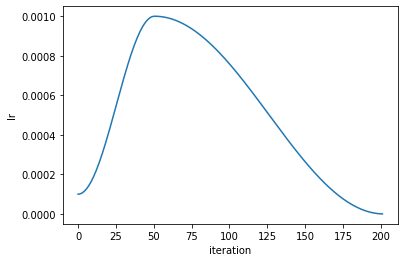

In [46]:
recorder.plotLRs()

In [47]:
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }

In [48]:
var model = modelInit()
let splitArray = [Array(model.differentiableVectorView.keyPaths[0..<9]), 
                  Array(model.differentiableVectorView.keyPaths[9...])]

In [49]:
let hpGroups: [[String: Float]] = [[HyperParams.lr: 0], [HyperParams.lr: 0.1]]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(for: model, steppers: [SGDStep()], stats: [], hpGroups: hpGroups, splitArray: splitArray)
}

In [50]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [51]:
learner.model.convs[0].norm.scale

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [52]:
learner.model.convs[3].norm.scale

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [53]:
learner.fit(1)

Epoch 0: [1.3714082, 0.538]                                                    


In [54]:
learner.model.convs[0].norm.scale

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [55]:
learner.model.convs[3].norm.scale

[ 1.0095962,  1.0085759,  1.0070801,  1.0093764,  1.0009989,  1.0235355,  1.0050647,  0.9930671,
 0.99825066,  1.0135125,  1.0283471,  1.0034746,   0.985408,  1.0360785,  1.0002128,  0.9581802,
   0.990947,  0.9868011,  1.0210855,  1.0174822,  0.9989061,  1.0120242,  0.9969078,  0.9905394,
  1.0008028,  1.0161784,  0.9812514,   1.000324,  0.9899246,  1.0035284,  0.9908847,    1.01557,
  0.9802788,  0.9886624, 0.98363256,  1.0192102,  1.0038047,  1.0741336,  0.9815482, 0.98594844,
  1.0147523,  1.0012901,  0.9970348,  0.9942427,  0.9739548,  1.0041414,  1.0081234, 0.99498504,
 0.98828405,  0.9703371,  1.0060086,  1.0222596, 0.99102724, 0.99113184,  0.9985431,  0.9991296,
 0.99020875, 0.99054545,  0.9980297,  0.9830312,   1.000831,  0.9956379, 0.98503053, 0.98695135]


In [56]:
public func parameterKeyPaths<M1, M2>(
    _ model: M1,
    _ kp: WritableKeyPath<M1.TangentVector, M2.TangentVector>,
    _ layer: M2) -> [WritableKeyPath<M1.TangentVector, TF>]
where M1: Layer, M2: Layer {
    return model.differentiableVectorView[keyPath: kp].keyPaths.map { kp.appending(path: $0) }
}

In [57]:
let kp = \(CNNModel.TangentVector).convs
let conv = model.convs
let bodyKeyPaths = parameterKeyPaths(model, kp, conv)